<a href="https://colab.research.google.com/github/AsinaMilic/image_classification_with_vision_transformers/blob/main/Compact_Convolutional_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compact Convolutional Transformers
# Nemam GPU memorije da stavim 512x512 rezoluciju slike...
**Author:** JA

**Description:** Compact Convolutional Transformers for efficient image classification.

As discussed in the [Vision Transformers (ViT)](https://arxiv.org/abs/2010.11929) paper,
a Transformer-based architecture for vision typically requires a larger dataset than
usual, as well as a longer pre-training schedule. [ImageNet-1k](http://imagenet.org/)
(which has about a million images) is considered to fall under the medium-sized data regime with
respect to ViTs. This is primarily because, unlike CNNs, ViTs (or a typical
Transformer-based architecture) do not have well-informed inductive biases (such as
convolutions for processing images). This begs the question: can't we combine the
benefits of convolution and the benefits of Transformers
in a single network architecture? These benefits include parameter-efficiency, and
self-attention to process long-range and global dependencies (interactions between
different regions in an image).

In [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/abs/2104.05704),
Hassani et al. present an approach for doing exactly this. They proposed the
**Compact Convolutional Transformer** (CCT) architecture. In this example, we will work on an
implementation of CCT and we will see how well it performs on the CIFAR-10 dataset.

If you are unfamiliar with the concept of self-attention or Transformers, you can read
[this chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11/r-3/312)
from  François Chollet's book *Deep Learning with Python*. This example uses
code snippets from another example,
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Addons, which can
be installed using the following command:

In [1]:
import os
import cv2
!pip install tensorflow==2.8.0
!pip install opencv-python
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 69.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [2]:
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.2 MB/s eta 0:00:00


## Imports

In [3]:
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

## Hyperparameters and constants

In [4]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 1#2#4#8#16#32#128
num_epochs = 40 #30
image_size = 256 #512

## Load CIFAR-10 dataset

In [5]:
num_classes = 10
input_shape = (512, 512, 3)

train_dir = '/content/drive/MyDrive/Chiro10_Smaller/train_512'
test_dir = '/content/drive/MyDrive/Chiro10_Smaller/test_512'
val_dir = '/content/drive/MyDrive/Chiro10_Smaller/val_512'

x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

# Učitajte slike za trening set
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            #print(file_path)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (input_shape[1], input_shape[0]))
            x_train.append(image)
            y_train.append([class_name])  # Convert class_name to a list

# Učitajte slike za test set
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            #print(file_path)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (input_shape[1], input_shape[0]))
            x_test.append(image)
            y_test.append([class_name])  # Convert class_name to a list

# Učitajte slike za validate set
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            #print(file_path)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (input_shape[1], input_shape[0]))
            x_val.append(image)
            y_val.append([class_name])  # Convert class_name to a list



# Konvertujte liste u numpy nizove
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

# Ispis dimenzija učitanih podataka
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

# Convert class names to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.reshape(-1))
y_test_encoded = label_encoder.transform(y_test.reshape(-1))
y_val_encoded = label_encoder.transform(y_val.reshape(-1))

x_train shape: (130, 512, 512, 3) - y_train shape: (130, 1)
x_test shape: (130, 512, 512, 3) - y_test shape: (130, 1)
x_val shape: (130, 512, 512, 3) - y_val shape: (130, 1)


## The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the
images. In a standard ViT, images are organized into uniform *non-overlapping* patches.
This eliminates the boundary-level information present in between different patches. This
is important for a neural network to effectively exploit the locality information. The
figure below presents an illustration of how images are organized into patches.

![](https://i.imgur.com/IkBK9oY.png)

We already know that convolutions are quite good at exploiting locality information. So,
based on this, the authors introduce an all-convolution mini-network to produce image
patches.

In [6]:

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None


## Stochastic depth for regularization

[Stochastic depth](https://arxiv.org/abs/1603.09382) is a regularization technique that
randomly drops a set of layers. During inference, the layers are kept as they are. It is
very much similar to [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) but only
that it operates on a block of layers rather than individual nodes present inside a
layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers
encoder.

In [7]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


## MLP for the Transformers encoder

In [8]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Data augmentation

In the [original paper](https://arxiv.org/abs/2104.05704), the authors use
[AutoAugment](https://arxiv.org/abs/1805.09501) to induce stronger regularization. For
this example, we will be using the standard geometric augmentations like random cropping
and flipping.

In [9]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

## The final CCT model

Another recipe introduced in CCT is attention pooling or sequence pooling. In ViT, only
the feature map corresponding to the class token is pooled and is then used for the
subsequent classification task (or any other downstream task). In CCT, outputs from the
Transformers encoder are weighted and then passed on to the final task-specific layer (in
this example, we do classification).

In [10]:

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Model training and evaluation

In [11]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,#Izmenjeno
        loss=keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, #label_smoothing = 0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train_encoded,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val_encoded),  # Use the validation data here
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test_encoded)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/40
130/130 [==============================] - 17s 99ms/step - loss: 2.8481 - accuracy: 0.1000 - top-5-accuracy: 0.3000 - val_loss: 2.5692 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.4923
Epoch 2/40
130/130 [==============================] - 15s 113ms/step - loss: 2.4570 - accuracy: 0.1692 - top-5-accuracy: 0.4154 - val_loss: 2.2804 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.1846
Epoch 3/40
130/130 [==============================] - 13s 102ms/step - loss: 2.3736 - accuracy: 0.1077 - top-5-accuracy: 0.4385 - val_loss: 2.3145 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.2385
Epoch 4/40
130/130 [==============================] - 13s 99ms/step - loss: 2.3752 - accuracy: 0.0692 - top-5-accuracy: 0.4231 - val_loss: 2.2958 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.2923
Epoch 5/40
130/130 [==============================] - 12s 94ms/step - loss: 2.2432 - accuracy: 0.1231 - top-5-accuracy: 0.5231 - val_loss: 2.4090 - val_accuracy: 0.0000e+00 - val_top-5-accur

Let's now visualize the training progress of the model.

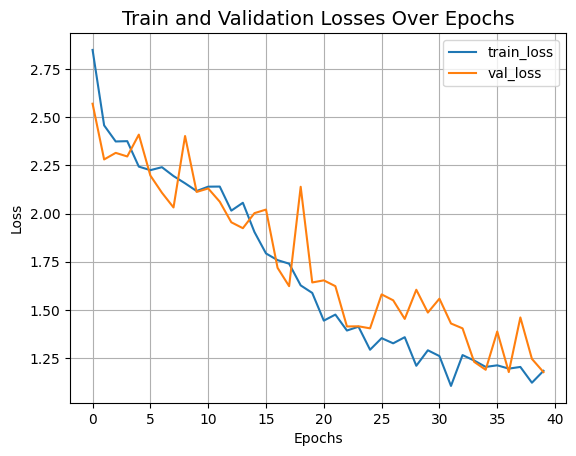

In [12]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

The CCT model we just trained has just **0.4 million** parameters, and it gets us to
~78% top-1 accuracy within 30 epochs. The plot above shows no signs of overfitting as
well. This means we can train this network for longer (perhaps with a bit more
regularization) and may obtain even better performance. This performance can further be
improved by additional recipes like cosine decay learning rate schedule, other data augmentation
techniques like [AutoAugment](https://arxiv.org/abs/1805.09501),
[MixUp](https://arxiv.org/abs/1710.09412) or
[Cutmix](https://arxiv.org/abs/1905.04899). With these modifications, the authors present
95.1% top-1 accuracy on the CIFAR-10 dataset. The authors also present a number of
experiments to study how the number of convolution blocks, Transformers layers, etc.
affect the final performance of CCTs.

For a comparison, a ViT model takes about **4.7 million** parameters and **100
epochs** of training to reach a top-1 accuracy of 78.22% on the CIFAR-10 dataset. You can
refer to
[this notebook](https://colab.research.google.com/gist/sayakpaul/1a80d9f582b044354a1a26c5cb3d69e5/image_classification_with_vision_transformer.ipynb)
to know about the experimental setup.

The authors also demonstrate the performance of Compact Convolutional Transformers on
NLP tasks and they report competitive results there.